In [1]:
import json
import numpy as np
import os
import pandas as pd
from pyrdf2vec import RDF2VecTransformer
from pyrdf2vec.embedders import Word2Vec
from pyrdf2vec.graphs import KG
from pyrdf2vec.walkers import RandomWalker
import plotly.express as px
import plotly.figure_factory as ff
import plotly.offline as plt
from rdflib import Graph, URIRef
from rdflib.namespace import RDF, SOSA
from sklearn.manifold import TSNE
from tqdm import tqdm

In [2]:
BASE_DIR = 'benchmarks/DASHB'
OUTPUT_DIR = os.path.join(BASE_DIR, 'results')

knowledge_graph = KG(
    os.path.join(BASE_DIR, 'graph.ttl')
)

In [3]:
transformer = RDF2VecTransformer(
    Word2Vec(epochs=10),
    walkers=[RandomWalker(4, 10, with_reverse=False, n_jobs=2)],
    # verbose=1
)

embeddings, literals = transformer.fit_transform(knowledge_graph, [e.name for e in knowledge_graph._entities])
embeddings = np.array(embeddings)
embeddings.shape

(6129, 100)

In [4]:
tsne = TSNE(n_components=2, random_state=0, learning_rate='auto', init='random')
Y = tsne.fit_transform(embeddings)

entity_tsne = pd.DataFrame({'x': Y[:, 0], 'y': Y[:, 1]})

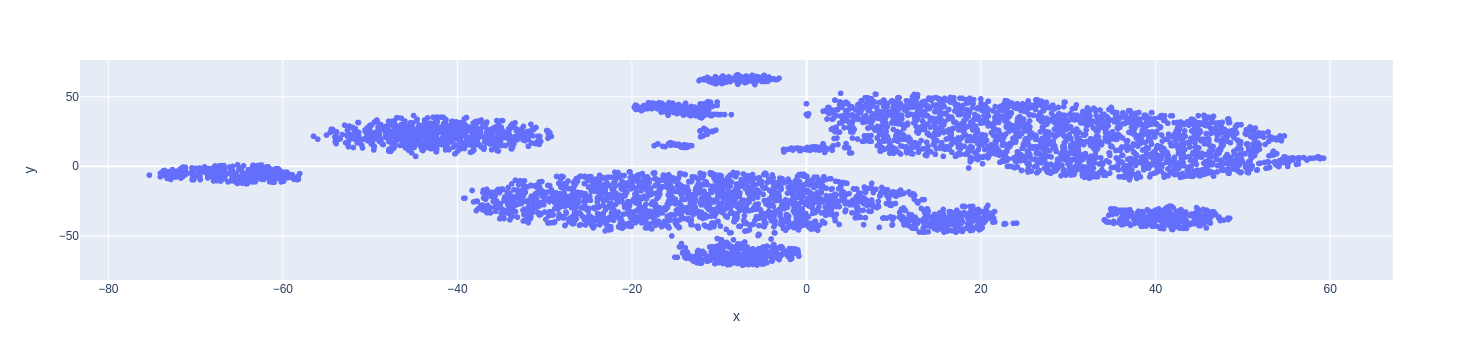

In [5]:
fig = px.scatter(entity_tsne, x='x', y='y')
fig.show()

In [6]:
graph = Graph()
graph.parse('benchmarks/DASHB/graph.ttl')

entities = pd.DataFrame()

entity_types = {}
for result in graph.subject_objects(predicate=RDF.type):
    entity = str(result[0])
    type_ = str(result[1])
    
    if entity not in entity_types.keys():
        entity_types[entity] = [type_]
    else:
        entity_types[entity].append(type_)
        
entities.loc[:, ('id')] = [e.name for e in knowledge_graph._entities]
entities.loc[:, ('type')] = [', '.join(entity_types[row['id']]) if row['id'] in entity_types.keys() else 'None' for idx, row in entities.iterrows()]

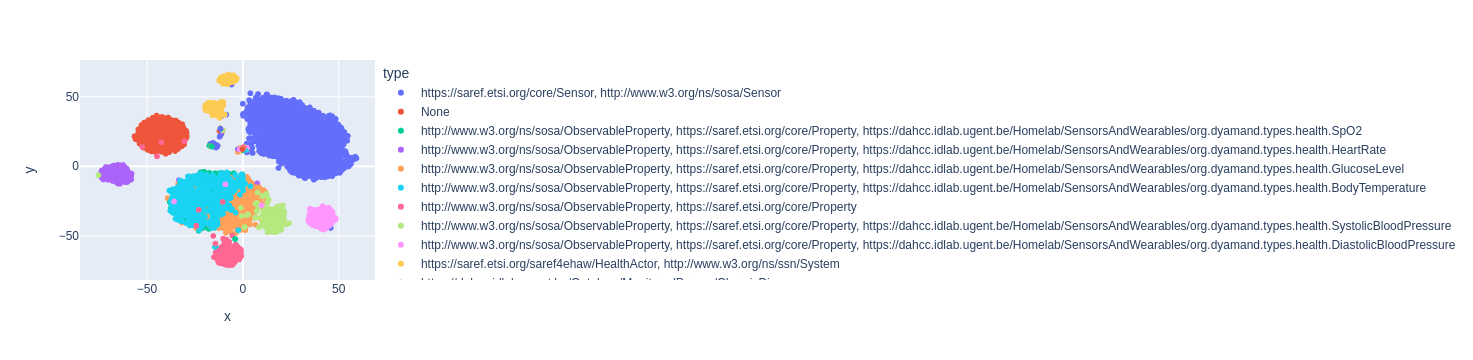

In [7]:
entity_tsne = entity_tsne.join(entities)

fig = px.scatter(entity_tsne, x='x', y='y', color='type', hover_data=['id'])
fig.show()

## User-User

In [8]:
patient_class = 'http://example.com/tx/patients/'
patients = entities[entities['id'].str.contains(patient_class)]

patients_tsne = entity_tsne.iloc[patients.index].copy()

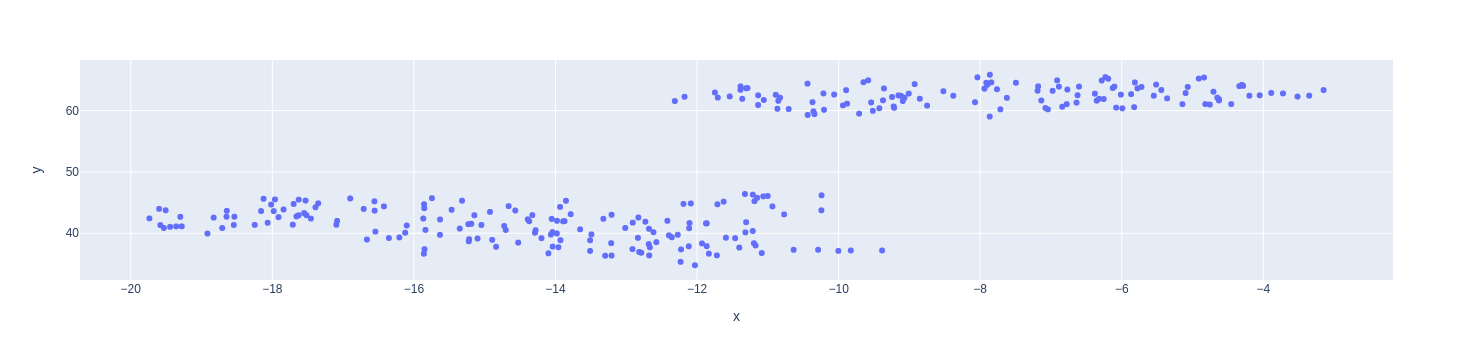

In [9]:
fig = px.scatter(patients_tsne, x='x', y='y', hover_data=['id'])
fig.show()

In [10]:
patient_diseases = {}
for idx, row in patients_tsne.iterrows():
    pid = row['id']
    
    patient_diseases[pid] = []

    for disease in graph.objects(subject=URIRef(pid), predicate=URIRef('https://saref.etsi.org/saref4ehaw/hasChronicDisease')):
        patient_diseases[pid].append(str(disease))

diseases = [patient_diseases[row['id']] if row['id'] in patient_diseases.keys() else 'None' for idx, row in patients_tsne.iterrows()]
patients_tsne.loc[:, ('diseases')] = [', '.join(patient_diseases[row['id']]) if patient_diseases[row['id']] else 'None' for idx, row in patients_tsne.iterrows()]
patients_tsne.loc[:, ('hasDiseases')] = [True if row['diseases'] == 'None' else False for idx, row in patients_tsne.iterrows()]
patients_tsne.loc[:, ('hasDiabetes')] = [True if 'http://example.com/tx/diseases/Diabetes' in patient_diseases[row['id']] else False for idx, row in patients_tsne.iterrows()]

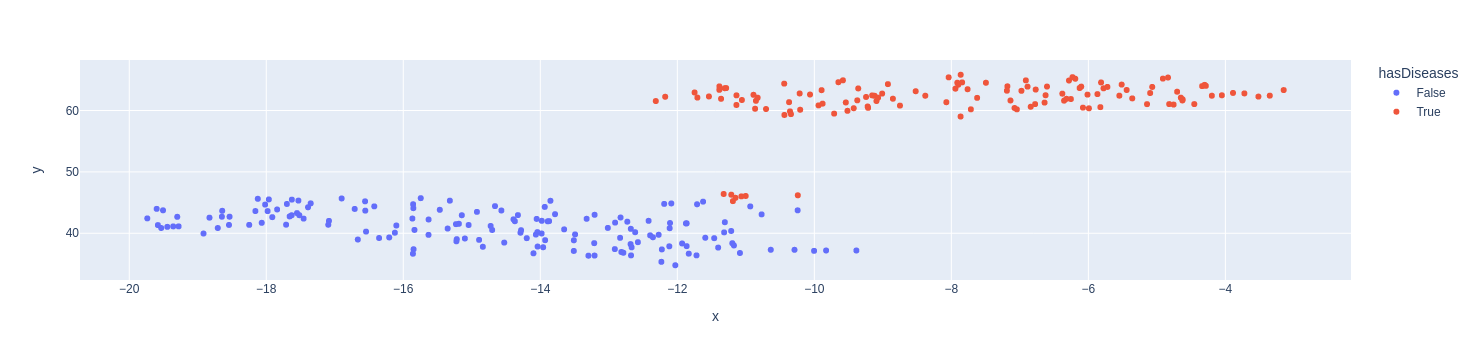

In [11]:
fig = px.scatter(patients_tsne, x='x', y='y', color='hasDiseases', hover_data=['id', 'diseases'])
fig.show()

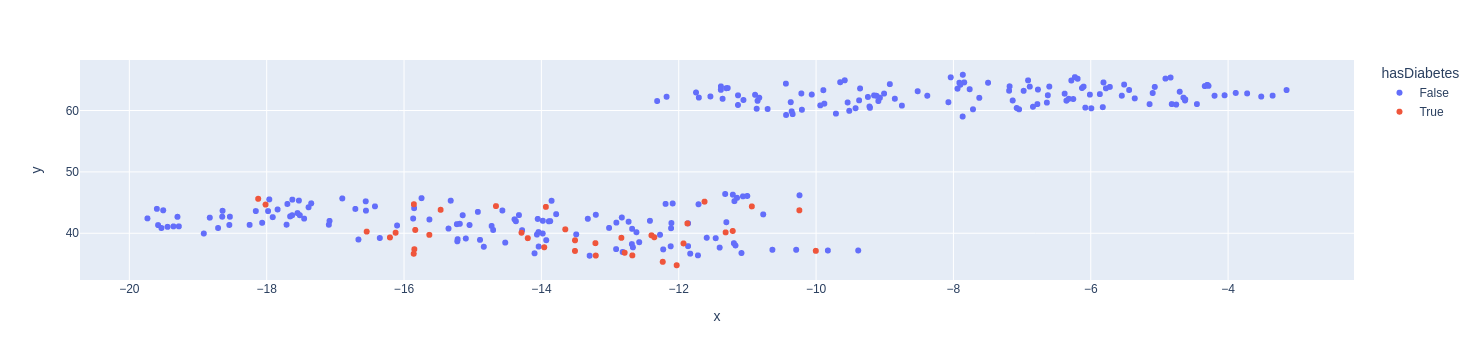

In [12]:
fig = px.scatter(patients_tsne, x='x', y='y', color='hasDiabetes', hover_data=['id', 'diseases'])
fig.show()

In [13]:
distances = {}

for idx, row in tqdm(patients.iterrows(), total=len(patients)):
    pid = row['id']
    distances[pid] = {}
    
    embedding = embeddings[idx]
    
    for idx_, row_ in patients.iterrows():
        pid_ = row_['id']
        embedding_ = embeddings[idx_]
        
        if pid == pid_:
            distances[pid][pid_] = 0
        elif pid_ in distances.keys():
            distances[pid][pid_] = distances[pid_][pid]
        else:
            distances[pid][pid_] = float(np.linalg.norm(embedding - embedding_))

100%|█████████████████████████████████████████| 282/282 [00:04<00:00, 70.25it/s]


In [14]:
print(sorted(distances['http://example.com/tx/patients/zplus_6'].items(), key=lambda x: x[1])[1:6])

[('http://example.com/tx/patients/zplus_209', 0.12380749732255936), ('http://example.com/tx/patients/zplus_127', 0.13027353584766388), ('http://example.com/tx/patients/zplus_14', 0.13102348148822784), ('http://example.com/tx/patients/zplus_161', 0.13144829869270325), ('http://example.com/tx/patients/zplus_79', 0.134846031665802)]


In [15]:
with open(os.path.join(OUTPUT_DIR, 'RDF2VecUU.json'), 'w') as output_f:
    output_f.write(json.dumps(distances))

## Item-Item

In [16]:
item_instances = [str(s) for s in graph.subjects(RDF.type, SOSA.ObservableProperty)]
items = entities[entities['id'].isin(item_instances)]

items_tsne = entity_tsne.iloc[items.index].copy()

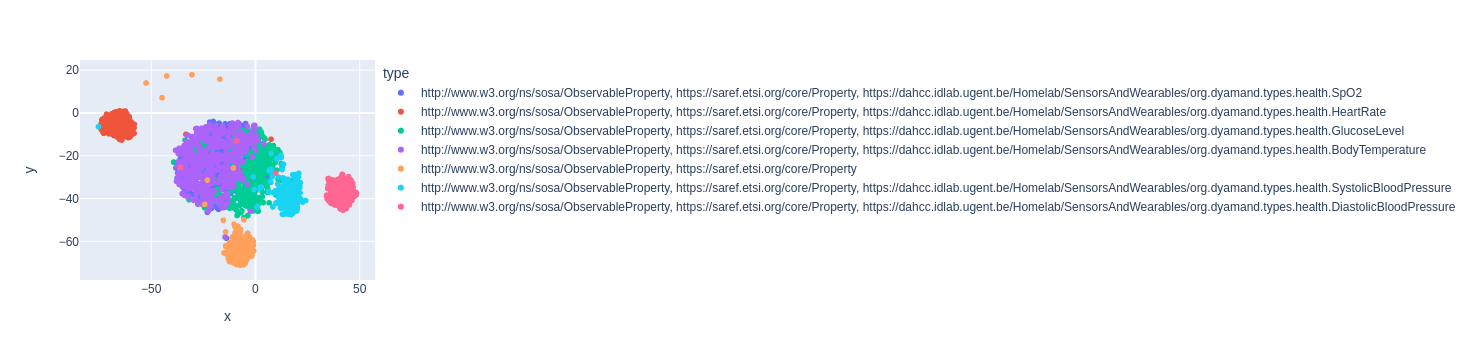

In [17]:
fig = px.scatter(items_tsne, x='x', y='y', color='type', hover_data=['id'])
fig.show()

In [18]:
distances = {}

for idx, row in tqdm(items.iterrows(), total=len(items)):
    iid = row['id']
    distances[iid] = {}
    
    embedding = embeddings[idx]
    
    for idx_, row_ in items.iterrows():
        iid_ = row_['id']
        embedding_ = embeddings[idx_]
        
        if iid == iid_:
            distances[iid][iid_] = 0
        elif iid_ in distances.keys():
            distances[iid][iid_] = distances[iid_][iid]
        else:
            distances[iid][iid_] = float(np.linalg.norm(embedding - embedding_))

100%|███████████████████████████████████████| 2826/2826 [06:18<00:00,  7.47it/s]


In [19]:
print(sorted(distances['https://webthing.protego.dynamicdashboard.ilabt.imec.be/things/zplus_160.60%253A77%253A71%253A7D%253A93%253AD7%252Fservice0009/properties/org.dyamand.types.health.GlucoseLevel'].items(), key=lambda x: x[1])[1:6])

[('https://webthing.protego.dynamicdashboard.ilabt.imec.be/things/zplus_254.B0%253A91%253A22%253AFB%253AD0%253A78%252Fservice0009/properties/org.dyamand.types.health.GlucoseLevel', 0.12347407639026642), ('https://webthing.protego.dynamicdashboard.ilabt.imec.be/things/zplus_272.00%253A1C%253A05%253AFF%253AA9%253A4E%252Fservice0029/properties/org.dyamand.types.health.SpO2', 0.12370053678750992), ('https://webthing.protego.dynamicdashboard.ilabt.imec.be/things/zplus_10.00%253A9D%253A6B%253A89%253A43%253ACD%252Fservice0025/properties/org.dyamand.types.health.SystolicBloodPressure', 0.1295880824327469), ('https://webthing.protego.dynamicdashboard.ilabt.imec.be/things/zplus_37.00%253A1C%253A05%253AFF%253AA9%253A4E%252Fservice0029/properties/org.dyamand.types.health.SpO2', 0.13445080816745758), ('https://webthing.protego.dynamicdashboard.ilabt.imec.be/things/zplus_202.60%253A77%253A71%253A7D%253A93%253AD7%252Fservice0009/properties/org.dyamand.types.health.GlucoseLevel', 0.13471347093582153)]

In [20]:
with open(os.path.join(OUTPUT_DIR, 'RDF2VecII.json'), 'w') as output_f:
    output_f.write(json.dumps(distances))